# Comparing electron id between nominal and super trigger cells



In [73]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal/analysis

import sys, os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import scripts.helpers as hlp 
hlp.set_default_style()

%connect_info

/home/naodell/work/hgcal/analysis
{
  "shell_port": 34025,
  "iopub_port": 33521,
  "stdin_port": 53519,
  "control_port": 51631,
  "hb_port": 40709,
  "ip": "127.0.0.1",
  "key": "99a8fb24-7076acea989016e0b46fa572",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1c95fe9d-7534-4415-aace-4958712c5c15.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [74]:
# get the data
samples = ['charged_pion_nominal', 'charged_pion_super', 'electron_nominal', 'electron_super']#, 'single_pion_nominal', 'single_pion_super']
evt_data = dict()
for sample in samples:
    
    # single file test
    infile = open(f'local_data/{sample}/output.pkl', 'rb')
    evts_particles  = pickle.load(infile)
    #evts_cells = pickle.load(infile)
    evts_clusters = pickle.load(infile)
        
    # match particles to clusters
    matched_data = []
    for ievt, particles in tqdm_notebook(enumerate(evts_particles), leave=True):
        if particles.size == 0:
            continue
        
        particles.query('abs(eta) > 2.2')

        clusters = evts_clusters[ievt].query('cl_pt > 5') # this cut is just to get around matching to a low energy cluster
        if clusters.shape[0] == 0:
            continue

        if 'electron' in sample:
            electrons = particles.query('abs(pid) == 11 and pt > 15')
            if electrons.shape[0] == 0:
                continue
            
            # match electron+ to cluster
            e_plus = electrons[electrons.pid == 11].sort_values(by='pt').iloc[0]
            cluster = hlp.associate_gen_to_cluster(e_plus, clusters)
            if not isinstance(cluster, type(None)): 
                matched_data.append(pd.concat([e_plus, cluster]))
                matched_data[-1]['pt_ratio'] = cluster.cl_pt/e_plus.pt
                matched_data[-1]['e_ratio'] = cluster.cl_e/e_plus.e

            # match electron- to cluster
            e_minus = electrons[electrons.pid == 11].sort_values(by='pt').iloc[0]
            cluster = hlp.associate_gen_to_cluster(e_minus, clusters)
            if not isinstance(cluster, type(None)): 
                matched_data.append(pd.concat([e_minus, cluster]))
                matched_data[-1]['pt_ratio'] = cluster.cl_pt/e_minus.pt
                matched_data[-1]['e_ratio'] = cluster.cl_e/e_minus.e

        elif 'neutral_pion' in sample:
            if 111 not in particles.pid.values or clusters.shape[0] == 0:
                continue

            # match neutral pion to cluster
            pion = particles.query('pid == 111').iloc[0]
            if 1.7 < abs(pion.eta) < 2.7:
                dphi = np.abs(pion.phi - clusters.cl_phi)
                dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
                deta = np.abs(pion.eta - clusters.cl_eta)
                dr = np.sqrt(deta**2 + dphi**2)

                cluster = clusters.loc[dr.idxmin()]
                matched_data.append(pd.concat([pion, cluster]))
                matched_data[-1]['pt_ratio'] = cluster.cl_pt/pion.pt
                matched_data[-1]['e_ratio'] = cluster.cl_e/pion.e
        elif 'charged_pion' in sample:
            pions = particles.query('abs(pid) == 211 and pt > 15')
            
            # match pion+ to cluster
            pion_plus = pions[pions.pid == 211].sort_values(by='pt').iloc[0]
            cluster = hlp.associate_gen_to_cluster(pion_plus, clusters)
            if not isinstance(cluster, type(None)): 
                matched_data.append(pd.concat([pion_plus, cluster]))
                matched_data[-1]['pt_ratio'] = cluster.cl_pt/pion_plus.pt
                matched_data[-1]['e_ratio'] = cluster.cl_e/pion_plus.e

            # match pion- to cluster
            pion_minus = pions[pions.pid == -211].sort_values(by='pt').iloc[0]
            cluster = hlp.associate_gen_to_cluster(pion_minus, clusters)
            if not isinstance(cluster, type(None)): 
                matched_data.append(pd.concat([pion_minus, cluster]))
                matched_data[-1]['pt_ratio'] = cluster.cl_pt/pion_minus.pt
                matched_data[-1]['e_ratio'] = cluster.cl_e/pion_minus.e

    evt_data[sample] = pd.DataFrame(matched_data).reset_index(drop=True)
    #    df_list.append(pd.DataFrame(matched_data, index=np.arange(len(matched_data))))
    #evt_data[sample] = pd.concat(df_list)

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


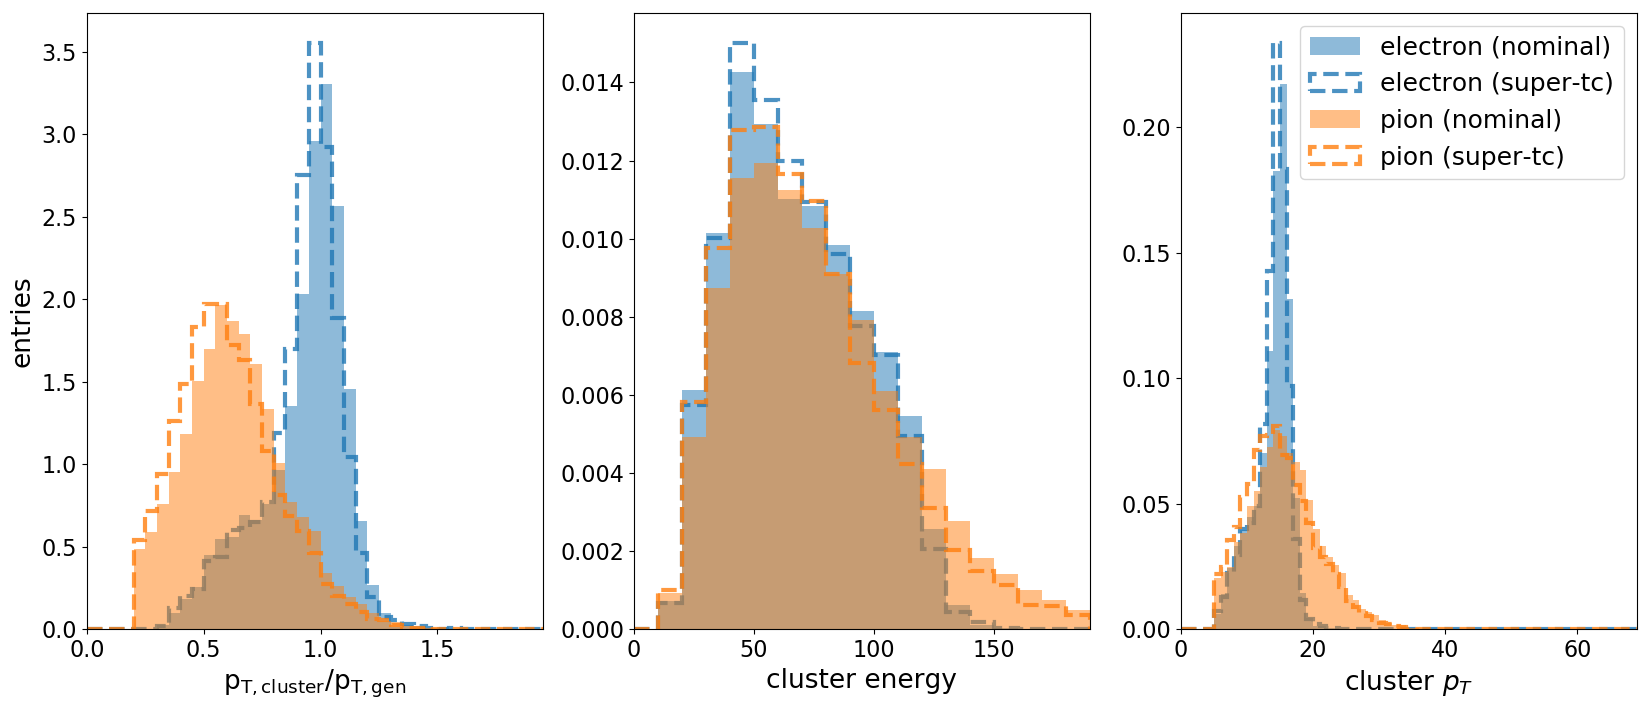

In [75]:
# makes some plots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=False, facecolor='white')

ax = axes[0]
binning = np.arange(0, 2, 0.05)
ax.hist(evt_data['electron_nominal'].pt_ratio, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].pt_ratio, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].pt_ratio, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].pt_ratio, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
#ax.hist(evt_data['neutral_pion_nominal'].pt_ratio, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
#ax.hist(evt_data['neutral_pion_super'].pt_ratio, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('$\sf p_{T, cluster}/p_{T, gen}$')
ax.set_ylabel('entries')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1]
binning = np.arange(0., 200., 10)
ax.hist(evt_data['electron_nominal'].cl_e, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].cl_e, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].cl_e, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].cl_e, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
#ax.hist(evt_data['neutral_pion_nominal'].cl_e, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
#ax.hist(evt_data['neutral_pion_super'].cl_e, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('cluster energy')
ax.set_xlim(binning[0], binning[-1])

ax = axes[2]
binning = np.arange(0., 70., 1)
ax.hist(evt_data['electron_nominal'].cl_pt, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].cl_pt, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].cl_pt, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].cl_pt, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
#ax.hist(evt_data['neutral_pion_nominal'].cl_pt, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
#ax.hist(evt_data['neutral_pion_super'].cl_pt, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel(r'cluster $p_{T}$')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['electron (nominal)', 'electron (super-tc)', 'pion (nominal)', 'pion (super-tc)'])

plt.savefig('plots/kinematics.png')
plt.show()

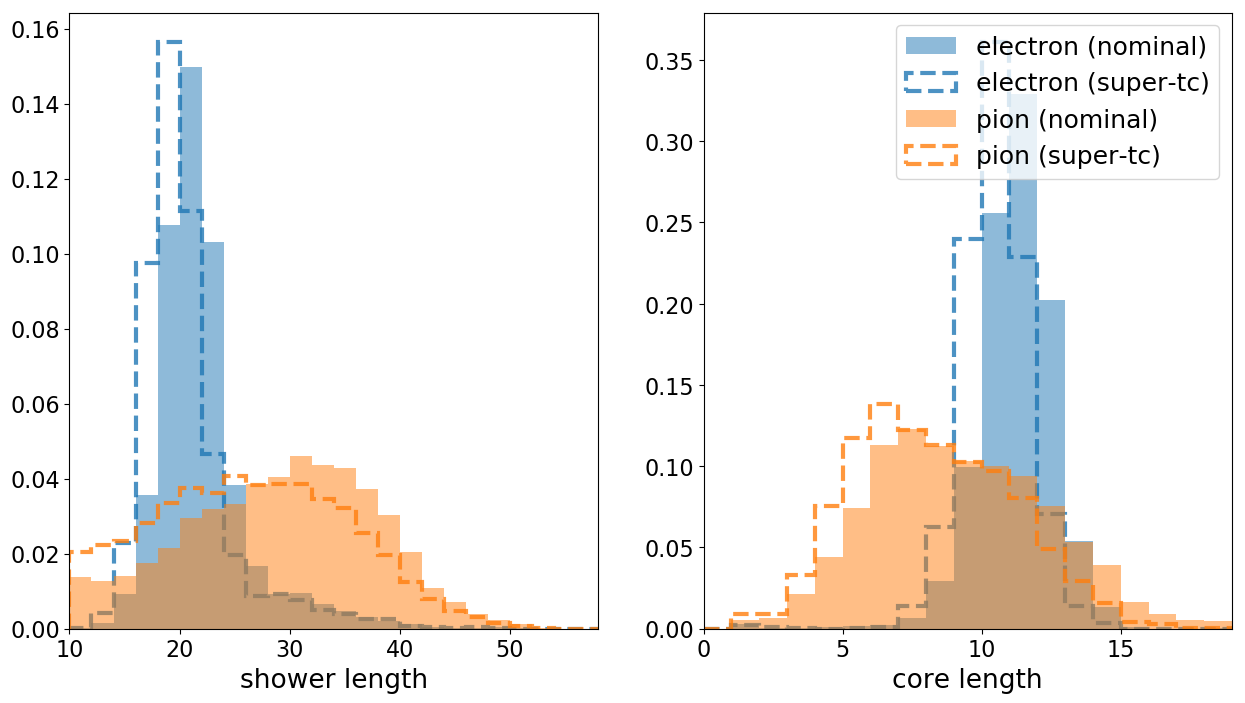

In [76]:
# shower length
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=False, facecolor='white')

ax = axes[0]
binning = np.arange(10., 60., 2)
ax.hist(evt_data['electron_nominal'].showerlength, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].showerlength, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].showerlength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].showerlength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
#ax.hist(evt_data['neutral_pion_nominal'].showerlength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
#ax.hist(evt_data['neutral_pion_super'].showerlength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('shower length')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1]
binning = np.arange(0., 20., 1)
ax.hist(evt_data['electron_nominal'].corelength, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].corelength, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].corelength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].corelength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
#ax.hist(evt_data['neutral_pion_nominal'].corelength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
#ax.hist(evt_data['neutral_pion_super'].corelength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('core length')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['electron (nominal)', 'electron (super-tc)', 'pion (nominal)', 'pion (super-tc)'])
plt.savefig('plots/shower_length.png')
plt.show()

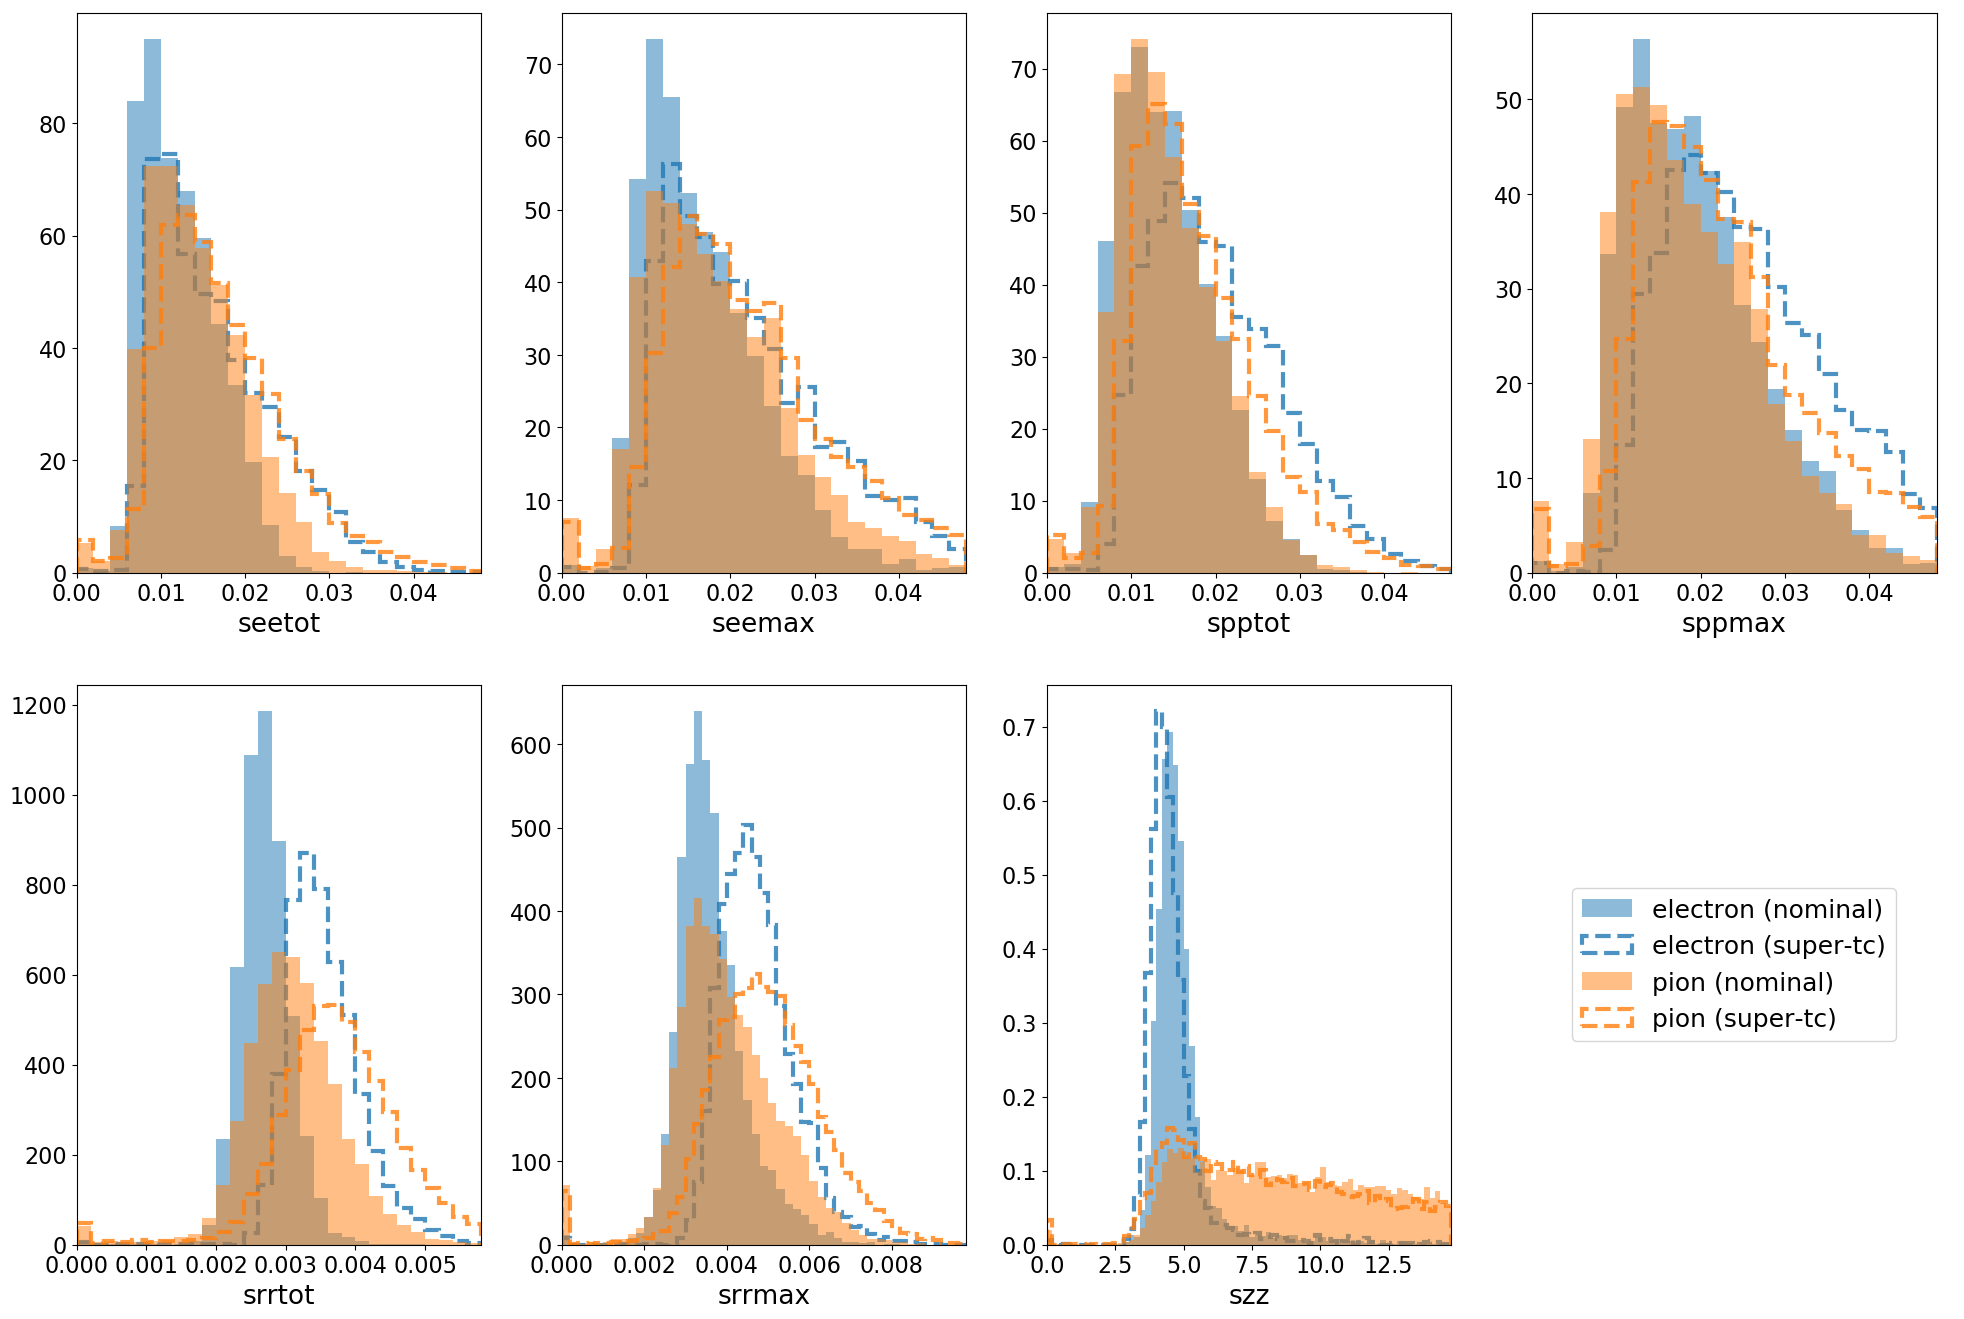

In [77]:
# widths
fig, axes = plt.subplots(2, 4, figsize=(24, 16), sharey=False, facecolor='white')

ax = axes[0][0]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].seetot, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].seetot, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].seetot, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].seetot, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('seetot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][1]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].seemax, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].seemax, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].seemax, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].seemax, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('seemax')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][2]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].spptot, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].spptot, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].spptot, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].spptot, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('spptot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][3]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].sppmax, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].sppmax, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].sppmax, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].sppmax, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('sppmax')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1][0]
binning = np.arange(0., 0.006, 0.0002)
ax.hist(evt_data['electron_nominal'].srrtot, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].srrtot, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].srrtot, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].srrtot, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('srrtot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1][1]
binning = np.arange(0., 0.01, 0.0002)
ax.hist(evt_data['electron_nominal'].srrmax, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['electron_super'].srrmax, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.hist(evt_data['charged_pion_nominal'].srrmax, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
ax.hist(evt_data['charged_pion_super'].srrmax, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('srrmax')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1][2]
binning = np.arange(0., 15., 0.2)
h_e_nom = ax.hist(evt_data['electron_nominal'].szz, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, density=True)
h_e_sup = ax.hist(evt_data['electron_super'].szz, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
h_pi_nom = ax.hist(evt_data['charged_pion_nominal'].szz, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, density=True)
h_pi_sup = ax.hist(evt_data['charged_pion_super'].szz, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, density=True)
ax.set_xlabel('szz')
ax.set_xlim(binning[0], binning[-1])

handles, labels = ax.get_legend_handles_labels()

axes[1][3].axis('off')
axes[1][3].legend(handles, ['electron (nominal)', 'electron (super-tc)', 'pion (nominal)', 'pion (super-tc)'], loc=10)

plt.savefig('plots/sigma_dist.png')
plt.show()

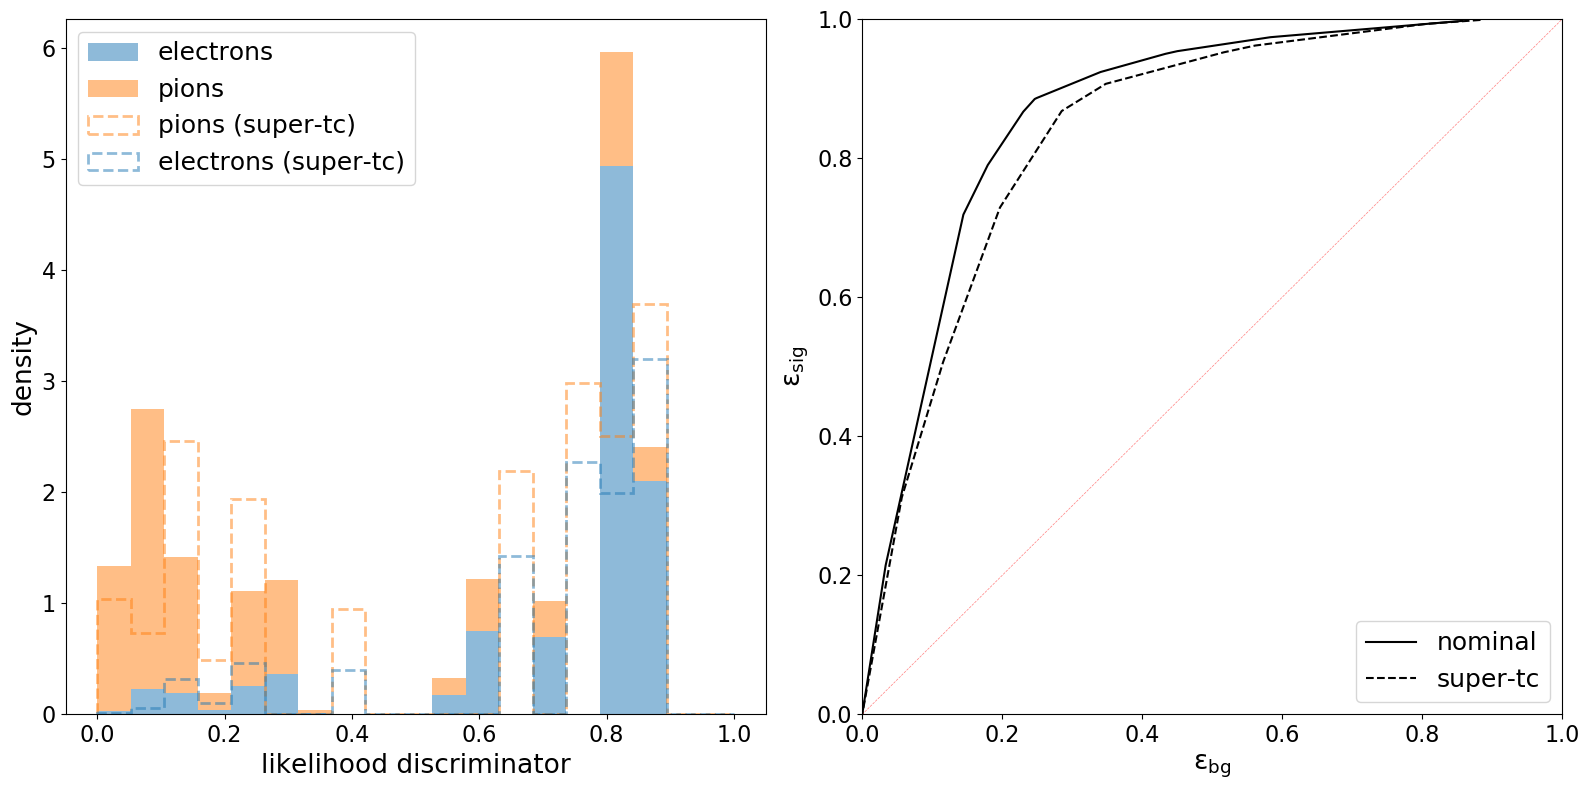

In [152]:
# calculate ROC curve for a few vars

#binning = np.arange(0., 15., 0.2)
feature = 'showerlength'
binning = np.linspace(0., 60., 50)
h1, _ = np.histogram(evt_data['electron_nominal'][feature], bins=binning, density=True)
h1_super, _ = np.histogram(evt_data['electron_super'][feature], bins=binning, density=True)
h2, _ = np.histogram(evt_data['charged_pion_nominal'][feature], bins=binning, density=True)
h2_super, _ = np.histogram(evt_data['charged_pion_super'][feature], bins=binning, density=True)

mask = (h1 > 0) & (h2 > 0)
h1 = h1[mask]
h2 = h2[mask]
lratio = h1/(h1 + h2)

mask = (h1_super > 0) & (h2_super > 0)
h1_super = h1_super[mask]
h2_super = h2_super[mask]
lratio_super = h1_super/(h1_super + h2_super)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
binning = np.linspace(0, 1, 20)
ax = axes[0]
hratio, _, _ = ax.hist([lratio, lratio], bins=binning, 
                       alpha=0.5, 
                       color=['C0', 'C1'],
                       density=True, 
                       stacked=True,
                       label=['electrons', 'pions'], 
                       weights=[h1, h2]
                      )
hratio_super, _, _ = ax.hist([lratio_super, lratio_super], bins=binning, 
                             histtype='step', 
                             linestyle='--', 
                             linewidth=2,
                             alpha = 0.5, 
                             color=['C0', 'C1'],
                             density=True, 
                             stacked=True,
                             label=['electrons (super-tc)', 'pions (super-tc)'], 
                             weights=[h1_super, h2_super],
                            )
l1 = hratio[0]
l2 = hratio[1] - hratio[0]
l1_super = hratio_super[0]
l2_super = hratio_super[1] - hratio_super[0]
ax.set_xlabel('likelihood discriminator')
ax.set_ylabel('density')
ax.legend()

ax = axes[1]
ax.plot(1 - np.cumsum(l2)/l2.sum(), 1 - np.cumsum(l1)/l1.sum(), 'k-', label='nominal')
ax.plot(1 - np.cumsum(l2_super)/l2_super.sum(), 1 - np.cumsum(l1_super)/l1_super.sum(), 'k--', label='super-tc')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, linewidth=0.5, label='_nolegend')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$\sf \epsilon_{bg}$')
ax.set_ylabel(r'$\sf \epsilon_{sig}$')
ax.legend()

plt.tight_layout()
plt.savefig('plots/test_roc.pdf')